#Qlearning & Sarsa cho bài toán Gridworld

##Định nghĩa môi trường, Agent chung:

In [88]:
import numpy as np
class environment:
  def __init__(self, grid_height, grid_width):
    self.height = grid_height
    self.width = grid_width
    self.start = []
    self.end = []
    self.reward = []
    self.walls = []
    self.map = np.array([i for i in range(grid_height * grid_width)])
    self.action_space = [0,1,2,3]
    self.terminal_states = [210, 224]
  def get_Map(self):
    print(self.map.reshape([self.width, self.height]))

  def get_NumState(self):
    return self.height * self.width

  def add_Wall(self, wall_cell):
    self.walls.append(wall_cell)

  def map_Designate(self, start_cell, end_cell, reward):
    self.start.append(start_cell)
    self.end.append(end_cell)
    self.reward.append(reward)

  def get_Observation(self, location, action):
    reward = -1
    new_location = 0
    # Action: UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3
    # Actions that get the agent out of the map, result in no change at all
    if action == 0: #UP
      if location - self.width < 0:
        new_location = location
        reward=-1
      else:
        new_location = location - self.width

    elif action == 1: #DOWN
      if location + self.width > self.height * self.width - 1:
        new_location = location
        reward=-1
      else:
        new_location = location + self.width

    elif action == 2: #LEFT
      if location % self.width == 0:
        new_location = location
        reward=-1
      else:
        new_location = location - 1

    elif action == 3: #RIGHT
      if (location + 1) % self.width == 0:
        new_location = location
        reward=-1
      else:
        new_location = location + 1

    # If the agent is at special locations, immediately moves to corresponding destinations, gain reward
    if new_location in self.start:
      idx = self.start.index(new_location)
      new_location = self.end[idx]
      reward = self.reward[idx]

    if new_location in self.walls:
      new_location = location   # ở nguyên chỗ
      reward = -1

    if new_location in self.terminal_states:
      reward = +100

    return new_location, self.action_space, reward


class Agent:
  def __init__(self, envir, init_location):
    # Trace the reward
    self.reward_trace = []
    # initialize the first location
    self.location_now = init_location
    # TODO: implement other features to the agent so it can perform MAB algorithm
    self.lastAction = None
    self.lastState = None
    self.value_table = {}    # format: {state : {action : [value, count]}}
    for state in range(envir.width*envir.height):
      self.value_table[state] = {}
      for action in envir.action_space:
        self.value_table[state][action] = [0,0]

  def get_TotalReward(self):
    return np.sum(self.reward_trace)





##Thiết kế cụ thể môi trường

In [89]:
# Create environment 15x15
Envir = environment(15, 15)


Envir.map_Designate(29,110,-10)
Envir.map_Designate(50,110,-10)
Envir.map_Designate(71,110,-10)
Envir.map_Designate(92,110,-10)

Envir.add_Wall(60)
Envir.add_Wall(90)
Envir.add_Wall(91)
Envir.add_Wall(92)
Envir.add_Wall(67)
Envir.add_Wall(68)
Envir.add_Wall(69)
Envir.add_Wall(135)
Envir.add_Wall(136)
Envir.add_Wall(137)
Envir.add_Wall(138)
Envir.add_Wall(139)
Envir.add_Wall(140)
Envir.add_Wall(141)
Envir.add_Wall(130)
Envir.add_Wall(145)
Envir.add_Wall(163)
Envir.add_Wall(208)




In [90]:
Envir.get_Map()

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
 [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44]
 [ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74]
 [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
 [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]
 [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
 [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
 [165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194]
 [195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
 [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224]]


#Q_learning

##Import thư viện

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import random

##Q_agent cho Q_learning:

In [92]:
class Q_agent(Agent):
    def __init__(self, envir, init_location, learning_rate, discount_factor, epsilon):
        super(Q_agent, self).__init__(envir, init_location)
        self.Q_table = {state: {action: [0.0, 0] for action in envir.action_space}
                        for state in range(envir.width * envir.height)}
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon

        self.lastState = None
        self.lastAction = None
        self.reward_trace = []
        self.location_now = init_location

    def getAction(self, observation):
        location, action_space, pre_reward = observation


        if pre_reward is not None and self.lastAction is not None and self.lastState is not None:
            max_future_q = max(self.Q_table[location][a][0] for a in action_space)
            old_value, count = self.Q_table[self.lastState][self.lastAction]
            new_value = old_value + self.alpha * (pre_reward + self.gamma * max_future_q - old_value)
            self.Q_table[self.lastState][self.lastAction] = [new_value, count + 1]
            self.reward_trace.append(pre_reward)


        if np.random.rand() < self.epsilon:
            action = random.choice(action_space)
        else:
            action = max(self.Q_table[location], key=lambda a: self.Q_table[location][a][0])

        # Cập nhật trạng thái và action trước
        self.lastState = location
        self.lastAction = action
        self.location_now = location

        return action


##Training phase:

In [93]:
init_location = 0
dummy_q_agent = Q_agent(envir=Envir, init_location=init_location,
                        learning_rate=0.1, discount_factor=1, epsilon=0.2)

num_episodes = 10000
max_steps = 200  # mỗi episode tối đa 500 bước
log_freq = 100
Data_plot1 = []

chosen_action = None

for episode in range(num_episodes):
    dummy_q_agent.location_now = init_location
    dummy_q_agent.lastState = None
    dummy_q_agent.lastAction = None

    total_reward = 0
    chosen_action = None

    for step in range(max_steps):
        # Lấy quan sát (current state, action_space, reward của action trước)
        env_observation = Envir.get_Observation(location=dummy_q_agent.location_now, action=chosen_action)
        location, action_space, reward = env_observation

        # Chọn hành động tiếp theo (và Q-update sẽ xảy ra trong hàm này)
        chosen_action = dummy_q_agent.getAction(observation=env_observation)

        total_reward += reward

        # Cập nhật vị trí agent về state mới
        dummy_q_agent.location_now = location

        # Nếu đạt trạng thái kết thúc → kết thúc episode
        if location in Envir.terminal_states:
            break

    # Logging
    if (episode + 1) % log_freq == 0:
        aver = np.mean(dummy_q_agent.reward_trace[-log_freq*max_steps:])
        Data_plot1.append(aver)
        print(f"Episode: {episode + 1}\tTotal reward: {total_reward}\tAverage: {aver:.3f}")


Episode: 100	Total reward: -20	Average: -0.814
Episode: 200	Total reward: 26	Average: -0.419
Episode: 300	Total reward: 64	Average: -0.046
Episode: 400	Total reward: 51	Average: 0.287
Episode: 500	Total reward: 66	Average: 0.634
Episode: 600	Total reward: 55	Average: 0.960
Episode: 700	Total reward: 70	Average: 1.256
Episode: 800	Total reward: 63	Average: 1.501
Episode: 900	Total reward: 65	Average: 1.696
Episode: 1000	Total reward: 51	Average: 1.817
Episode: 1100	Total reward: 57	Average: 1.834
Episode: 1200	Total reward: 61	Average: 1.835
Episode: 1300	Total reward: 62	Average: 1.835
Episode: 1400	Total reward: 61	Average: 1.847
Episode: 1500	Total reward: 63	Average: 1.852
Episode: 1600	Total reward: 66	Average: 1.857
Episode: 1700	Total reward: 63	Average: 1.847
Episode: 1800	Total reward: 56	Average: 1.846
Episode: 1900	Total reward: 66	Average: 1.825
Episode: 2000	Total reward: 50	Average: 1.827
Episode: 2100	Total reward: 66	Average: 1.809
Episode: 2200	Total reward: 61	Average:

##Biểu diễn qua biểu đồ:

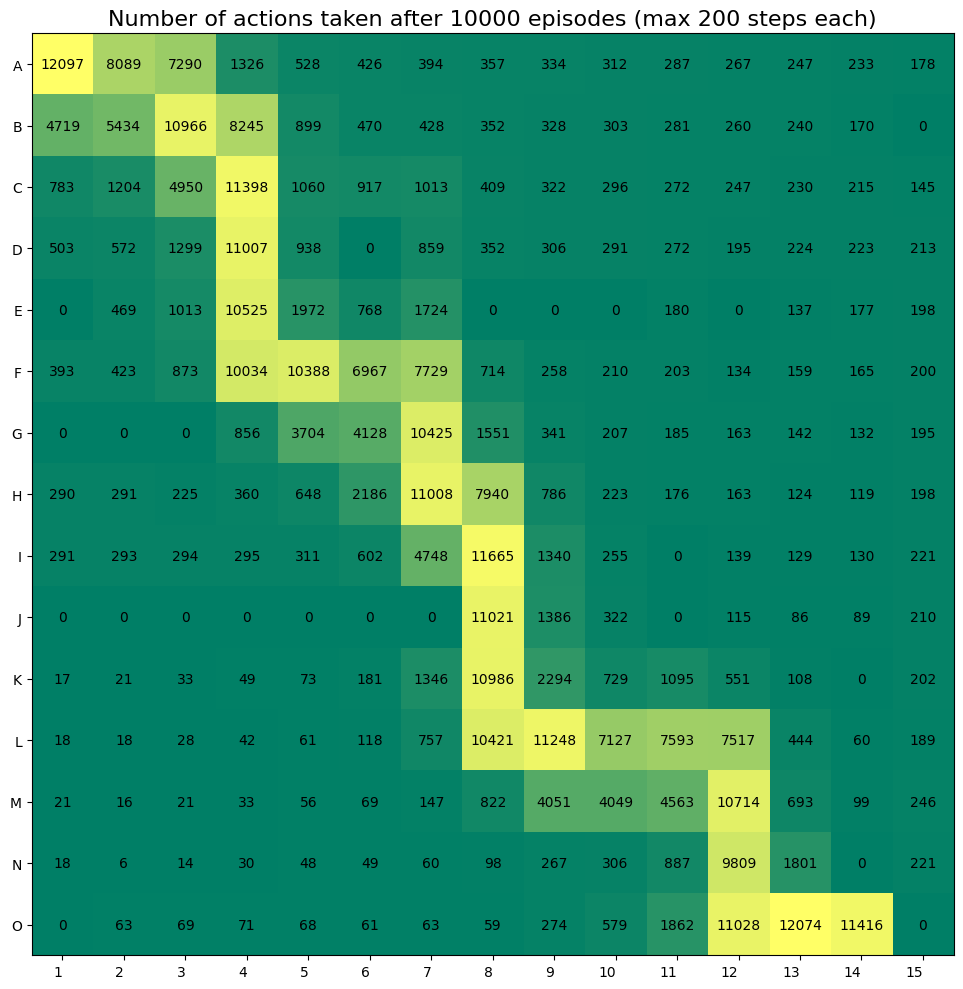

In [94]:
Y_Cord = [chr(65 + i) for i in range(Envir.height)]   # A → O (15 hàng)
X_Cord = [str(i + 1) for i in range(Envir.width)]     # 1 → 15 (15 cột)

Map = np.zeros([Envir.height, Envir.width])
for i in range(Envir.height):
    for j in range(Envir.width):
        state = i * Envir.width + j
        if state in dummy_q_agent.Q_table:
            list_freq = [f[1] for f in dummy_q_agent.Q_table[state].values()]
            Map[i][j] = sum(list_freq)
        else:
            Map[i][j] = 0

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(Map, cmap="summer")

ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        ax.text(j, i, int(Map[i, j]), ha="center", va="center", color="k")

ax.set_title(f"Number of actions taken after {num_episodes} episodes (max {max_steps} steps each)",
             fontdict={'size':16})
fig.tight_layout()
plt.show()


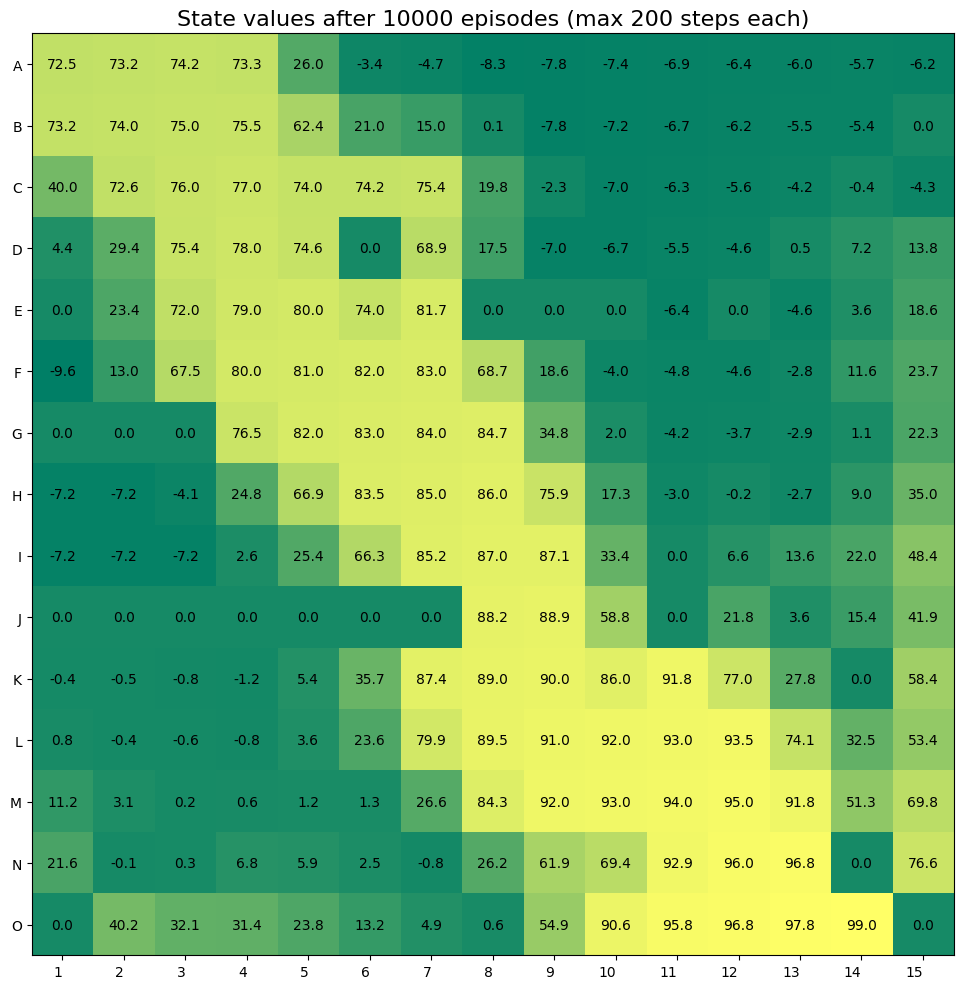

In [95]:
Y_Cord = [chr(65 + i) for i in range(Envir.height)]   # A → O (15 hàng)
X_Cord = [str(i + 1) for i in range(Envir.width)]     # 1 → 15 (15 cột)

# === State Value Map ===
Map = np.zeros([Envir.height, Envir.width])
for i in range(Envir.height):
    for j in range(Envir.width):
        state = i * Envir.width + j
        if state in dummy_q_agent.Q_table:
            # Lấy trung bình giá trị Q của các hành động tại state đó
            list_value = [round(f[0], 1) for f in dummy_q_agent.Q_table[state].values()]
            Map[i][j] = round(np.mean(list_value), 1)
        else:
            Map[i][j] = 0

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(Map, cmap="summer")

# Hiển thị ticks
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

# Ghi giá trị lên từng ô
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        ax.text(j, i, f"{Map[i, j]:.1f}", ha="center", va="center", color="k")

# Tiêu đề cập nhật theo episode
ax.set_title(f"State values after {num_episodes} episodes (max {max_steps} steps each)",
             fontdict={'size':16})
fig.tight_layout()
plt.show()


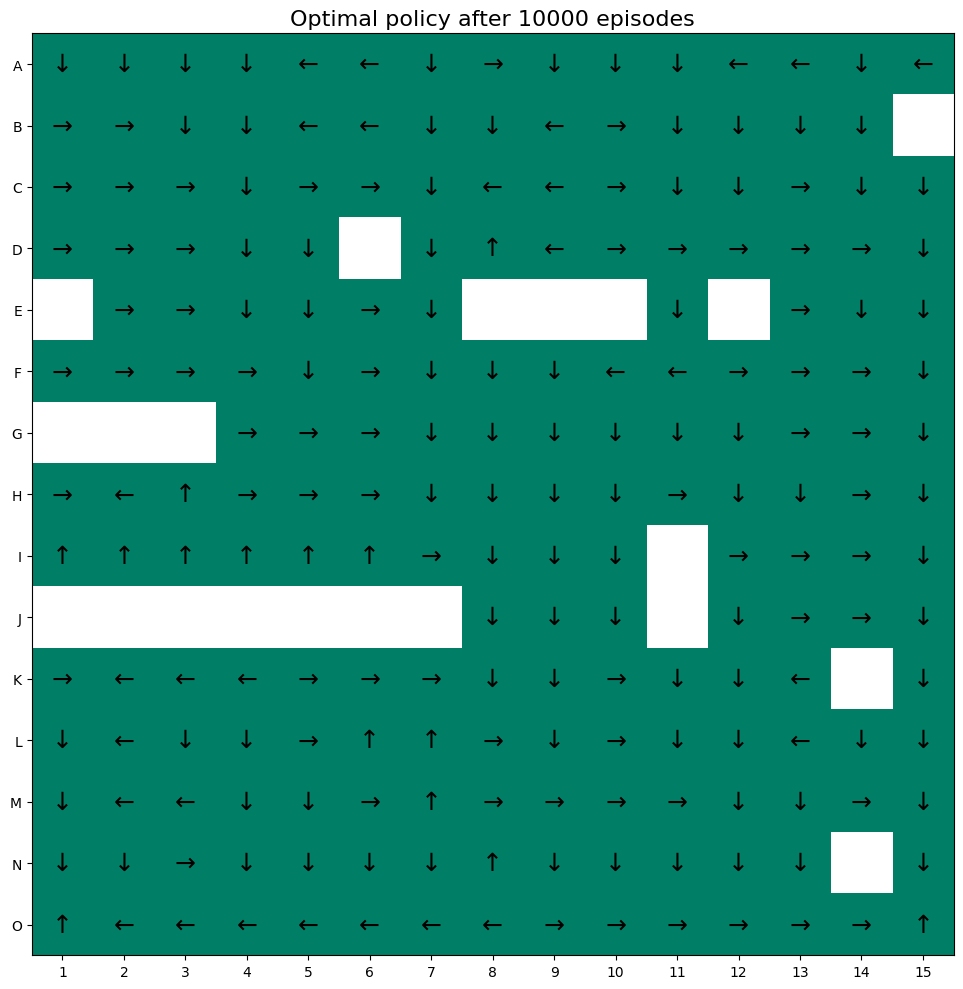

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# ====== Nhãn cho các cột và hàng ======
Y_Cord = [chr(65 + i) for i in range(Envir.height)]   # A → O (15 hàng)
X_Cord = [str(i + 1) for i in range(Envir.width)]     # 1 → 15 (15 cột)

# ====== Giải mã hành động sang mũi tên ======
def decode_action(action):
    return {
        0: "\u2191",  # UP
        1: "\u2193",  # DOWN
        2: "\u2190",  # LEFT
        3: "\u2192"   # RIGHT
    }.get(action, "")

# ====== Khởi tạo bản đồ ======
Map = np.zeros((Envir.height, Envir.width))
Map_labels = [['' for _ in range(Envir.width)] for _ in range(Envir.height)]

# ====== Vẽ chính sách (policy) ======
for i in range(Envir.height):
    for j in range(Envir.width):
        state = i * Envir.width + j

        # Bỏ qua tường và điểm đặc biệt
        if state in Envir.walls or state in Envir.start:
            Map[i][j] = np.nan
            continue

        # Nếu state tồn tại trong Q-table
        if state in dummy_q_agent.Q_table:
            best_action, best_value = None, -np.inf

            # Duyệt qua các hành động
            for action, (q_val, _) in dummy_q_agent.Q_table[state].items():
                next_state, _, _ = Envir.get_Observation(state, action)
                if next_state == state:  # không di chuyển được (tường, biên)
                    continue
                if q_val > best_value:
                    best_value = q_val
                    best_action = action

            # Ghi mũi tên hành động tốt nhất
            if best_action is not None:
                Map_labels[i][j] = decode_action(best_action)
            else:
                Map[i][j] = np.nan
        else:
            Map[i][j] = np.nan

# ====== Vẽ bản đồ ======
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Map, cmap='summer', interpolation='none')

# Gán nhãn trục
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Hiển thị mũi tên
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        if not np.isnan(Map[i][j]):
            ax.text(j, i, Map_labels[i][j],
                    ha="center", va="center", color="k", fontsize=18)

ax.set_title(f"Optimal policy after {num_episodes} episodes", fontsize=16)
fig.tight_layout()
plt.show()


In [97]:
Envir.get_Map()

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
 [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44]
 [ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74]
 [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
 [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]
 [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
 [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
 [165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194]
 [195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
 [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224]]


#SARSA (tương tự)

In [98]:
import numpy as np
import random

class SARSA_agent(Agent):
    def __init__(self, envir, init_location, learning_rate, discount_factor, epsilon):
        super(SARSA_agent, self).__init__(envir, init_location)
        self.Q_table = {
            state: {action: [0.0, 0] for action in envir.action_space}
            for state in range(envir.width * envir.height)
        }
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon

        self.lastState = None
        self.lastAction = None
        self.reward_trace = []
        self.location_now = init_location

    def getAction(self, observation):
        location, action_space, pre_reward = observation

        # ====== 1️⃣ Cập nhật Q-value nếu có state trước đó ======
        if pre_reward is not None and self.lastAction is not None and self.lastState is not None:
            # Lấy next_action theo epsilon-greedy (SARSA)
            if np.random.rand() < self.epsilon:
                next_action = random.choice(action_space)
            else:
                next_action = max(self.Q_table[location], key=lambda a: self.Q_table[location][a][0])

            old_value, count = self.Q_table[self.lastState][self.lastAction]
            next_q = self.Q_table[location][next_action][0]

            # 🎯 Công thức SARSA
            new_value = old_value + self.alpha * (pre_reward + self.gamma * next_q - old_value)

            # Cập nhật Q-table
            self.Q_table[self.lastState][self.lastAction] = [new_value, count + 1]
            self.reward_trace.append(pre_reward)

        # ====== 2️⃣ Chọn hành động hiện tại (epsilon-greedy) ======
        if np.random.rand() < self.epsilon:
            action = random.choice(action_space)
        else:
            action = max(self.Q_table[location], key=lambda a: self.Q_table[location][a][0])

        # ====== 3️⃣ Cập nhật trạng thái và hành động trước ======
        self.lastState = location
        self.lastAction = action
        self.location_now = location

        return action


In [99]:
init_location = 0
dummy_sarsa_agent = SARSA_agent(envir=Envir, init_location=init_location,
                                learning_rate=0.1, discount_factor=1, epsilon=0.2)

num_episodes = 10000
max_steps = 500
log_freq = 100
Data_plot2 = []

chosen_action = None

for episode in range(num_episodes):
    dummy_sarsa_agent.location_now = init_location
    dummy_sarsa_agent.lastState = None
    dummy_sarsa_agent.lastAction = None

    total_reward = 0
    chosen_action = None

    for step in range(max_steps):
        env_observation = Envir.get_Observation(location=dummy_sarsa_agent.location_now, action=chosen_action)
        location, action_space, reward = env_observation

        chosen_action = dummy_sarsa_agent.getAction(observation=env_observation)

        total_reward += reward
        dummy_sarsa_agent.location_now = location

        if location in Envir.terminal_states:
            break

    # Logging
    if (episode + 1) % log_freq == 0:
        aver = np.mean(dummy_sarsa_agent.reward_trace[-log_freq*max_steps:])
        Data_plot2.append(aver)
        print(f"Episode: {episode + 1}\tTotal reward: {total_reward}\tAverage: {aver:.3f}")


Episode: 100	Total reward: -124	Average: -0.633
Episode: 200	Total reward: 37	Average: -0.443
Episode: 300	Total reward: -12	Average: -0.286
Episode: 400	Total reward: 61	Average: -0.147
Episode: 500	Total reward: 46	Average: -0.020
Episode: 600	Total reward: 52	Average: 0.156
Episode: 700	Total reward: 57	Average: 0.336
Episode: 800	Total reward: 56	Average: 0.507
Episode: 900	Total reward: 67	Average: 0.674
Episode: 1000	Total reward: 63	Average: 0.828
Episode: 1100	Total reward: 62	Average: 0.979
Episode: 1200	Total reward: 60	Average: 1.120
Episode: 1300	Total reward: 59	Average: 1.257
Episode: 1400	Total reward: 65	Average: 1.388
Episode: 1500	Total reward: 61	Average: 1.502
Episode: 1600	Total reward: 65	Average: 1.608
Episode: 1700	Total reward: 60	Average: 1.699
Episode: 1800	Total reward: 58	Average: 1.782
Episode: 1900	Total reward: 53	Average: 1.843
Episode: 2000	Total reward: 55	Average: 1.895
Episode: 2100	Total reward: 59	Average: 1.931
Episode: 2200	Total reward: 59	Aver

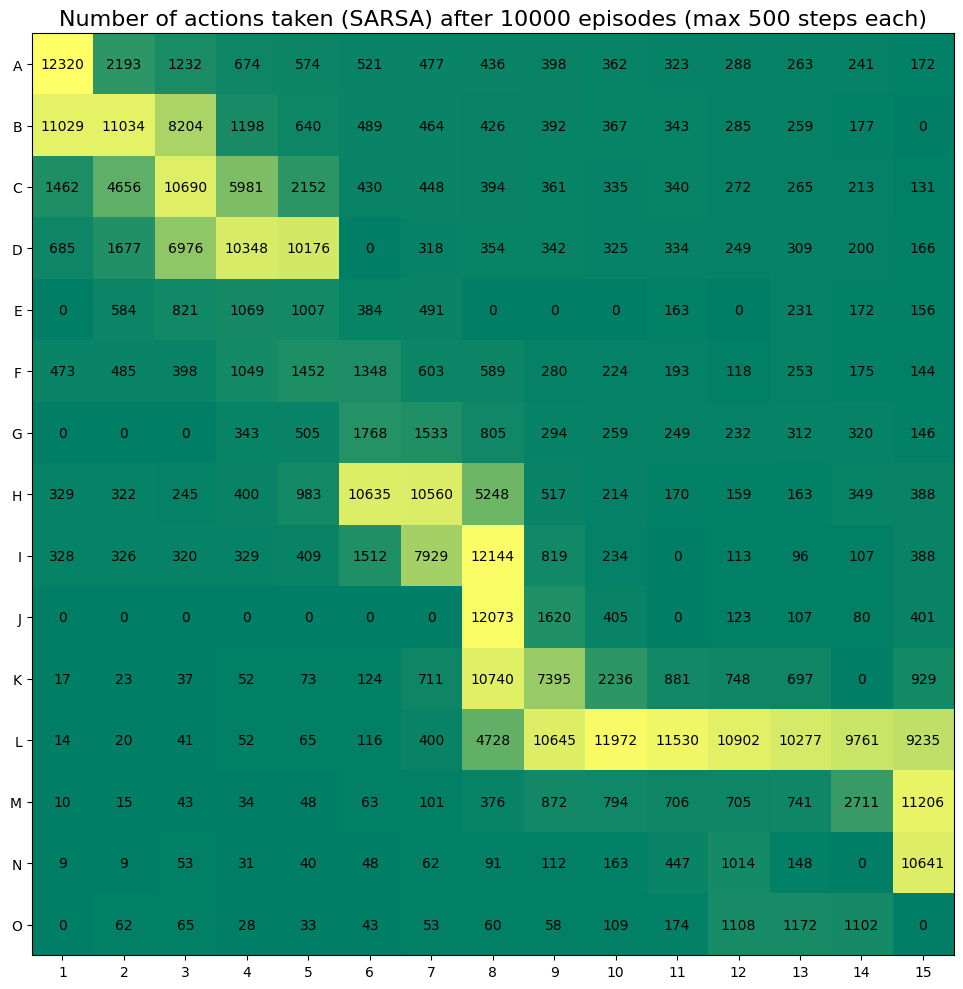

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# === Gán nhãn trục ===
Y_Cord = [chr(65 + i) for i in range(Envir.height)]   # A → O (15 hàng)
X_Cord = [str(i + 1) for i in range(Envir.width)]     # 1 → 15 (15 cột)

# === Map tần suất hành động của SARSA agent ===
Map = np.zeros((Envir.height, Envir.width))

for i in range(Envir.height):
    for j in range(Envir.width):
        state = i * Envir.width + j
        if state in dummy_sarsa_agent.Q_table:
            list_freq = [f[1] for f in dummy_sarsa_agent.Q_table[state].values()]
            Map[i, j] = sum(list_freq)
        else:
            Map[i, j] = 0

# === Vẽ heatmap ===
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Map, cmap="summer", origin="upper")

# Gán nhãn trục
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Không xoay nhãn
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Ghi số lượng lên từng ô
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        ax.text(j, i, int(Map[i, j]), ha="center", va="center", color="k")

# Tiêu đề
ax.set_title(f"Number of actions taken (SARSA) after {num_episodes} episodes (max {max_steps} steps each)",
             fontdict={'size':16})

fig.tight_layout()
plt.show()


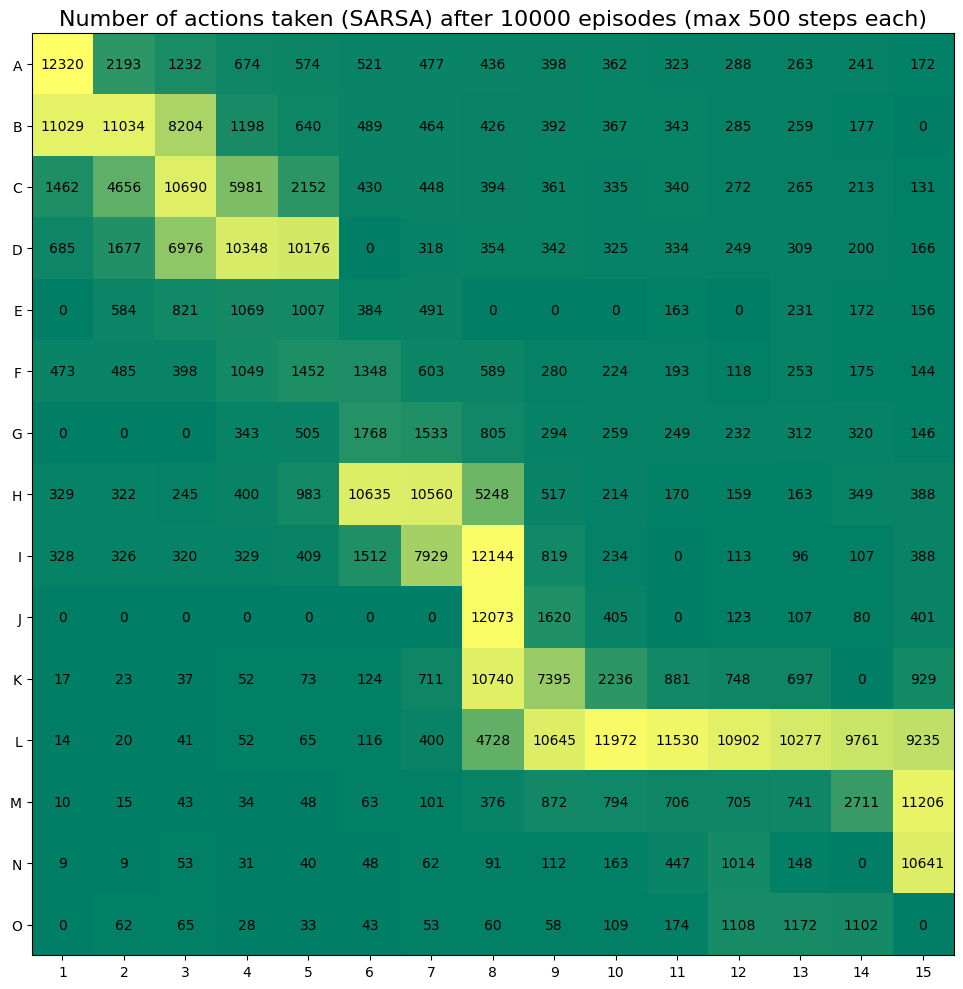

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# === Gán nhãn trục ===
Y_Cord = [chr(65 + i) for i in range(Envir.height)]   # A → O (15 hàng)
X_Cord = [str(i + 1) for i in range(Envir.width)]     # 1 → 15 (15 cột)

# === Map tần suất hành động của SARSA agent ===
Map = np.zeros((Envir.height, Envir.width))

for i in range(Envir.height):
    for j in range(Envir.width):
        state = i * Envir.width + j
        if state in dummy_sarsa_agent.Q_table:
            list_freq = [f[1] for f in dummy_sarsa_agent.Q_table[state].values()]
            Map[i, j] = sum(list_freq)
        else:
            Map[i, j] = 0

# === Vẽ heatmap ===
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Map, cmap="summer", origin="upper")

# Gán nhãn trục
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Không xoay nhãn
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Ghi số lượng lên từng ô
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        ax.text(j, i, int(Map[i, j]), ha="center", va="center", color="k")

# Tiêu đề
ax.set_title(f"Number of actions taken (SARSA) after {num_episodes} episodes (max {max_steps} steps each)",
             fontdict={'size':16})

fig.tight_layout()
plt.show()


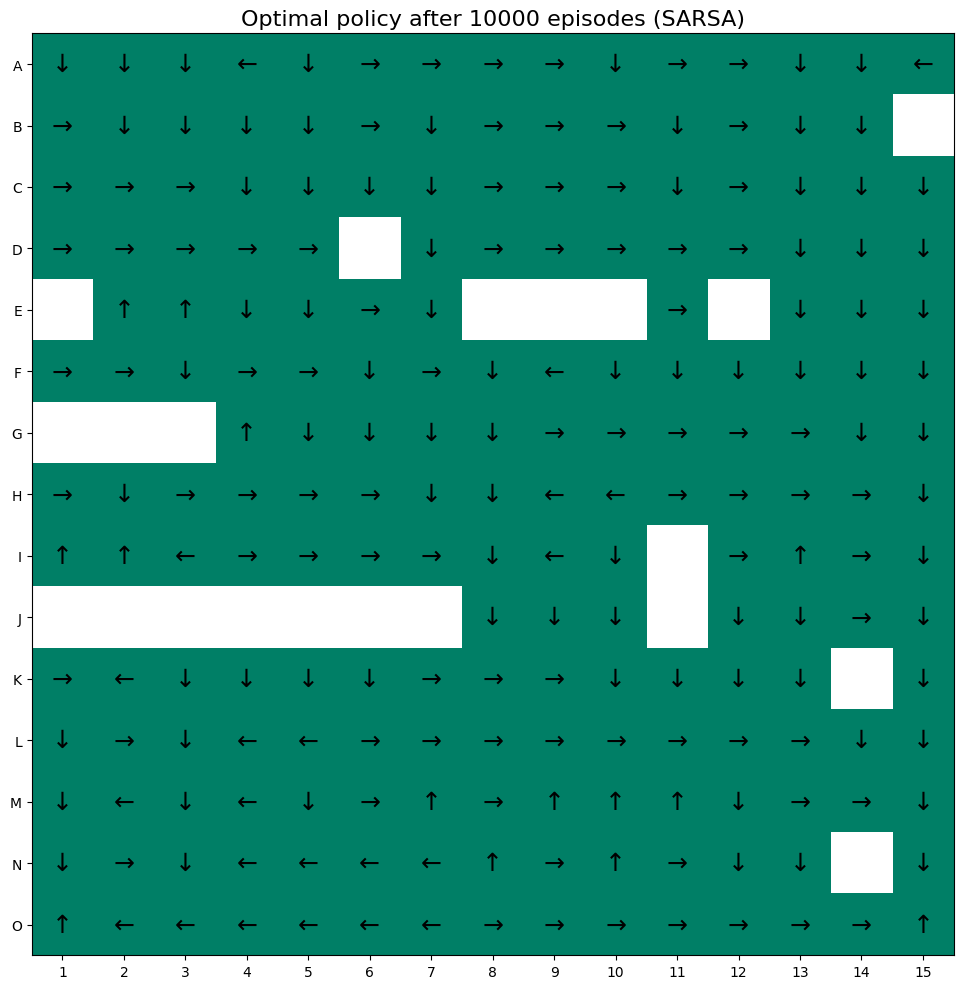

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# ====== Nhãn cho các cột và hàng ======
Y_Cord = [chr(65 + i) for i in range(Envir.height)]   # A → O (15 hàng)
X_Cord = [str(i + 1) for i in range(Envir.width)]     # 1 → 15 (15 cột)

# ====== Giải mã hành động sang mũi tên ======
def decode_action(action):
    return {
        0: "\u2191",  # UP
        1: "\u2193",  # DOWN
        2: "\u2190",  # LEFT
        3: "\u2192"   # RIGHT
    }.get(action, "")

# ====== Khởi tạo bản đồ ======
Map = np.zeros((Envir.height, Envir.width))
Map_labels = [['' for _ in range(Envir.width)] for _ in range(Envir.height)]

# ====== Vẽ chính sách (policy) ======
for i in range(Envir.height):
    for j in range(Envir.width):
        state = i * Envir.width + j

        # Bỏ qua tường và điểm đặc biệt
        if state in Envir.walls or state in Envir.start:
            Map[i][j] = np.nan
            continue

        # Nếu state tồn tại trong Q-table
        if state in dummy_sarsa_agent.Q_table:
            best_action, best_value = None, -np.inf

            # Duyệt qua các hành động
            for action, (q_val, _) in dummy_sarsa_agent.Q_table[state].items():
                next_state, _, _ = Envir.get_Observation(state, action)
                if next_state == state:  # không di chuyển được (tường, biên)
                    continue
                if q_val > best_value:
                    best_value = q_val
                    best_action = action

            # Ghi mũi tên hành động tốt nhất
            if best_action is not None:
                Map_labels[i][j] = decode_action(best_action)
            else:
                Map[i][j] = np.nan
        else:
            Map[i][j] = np.nan

# ====== Vẽ bản đồ ======
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Map, cmap='summer', interpolation='none')

# Gán nhãn trục
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Hiển thị mũi tên
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        if not np.isnan(Map[i][j]):
            ax.text(j, i, Map_labels[i][j],
                    ha="center", va="center", color="k", fontsize=18)

# ====== Tiêu đề ======
ax.set_title(f"Optimal policy after {num_episodes} episodes (SARSA)", fontsize=16)
fig.tight_layout()
plt.show()


##So sánh avg reward trung bình mỗi episode

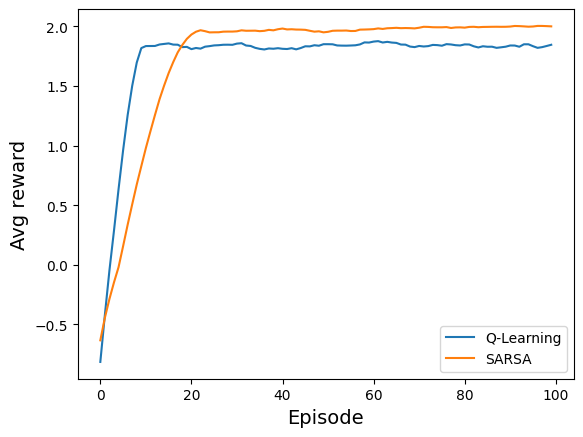

In [103]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(Data_plot1, label="Q-Learning")
plt.plot(Data_plot2, label="SARSA")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Avg reward", fontsize=14)
plt.legend()
plt.show()

##Thực tế đường đi robot sẽ áp dụng khi đi:

Q-learning path length: 28 steps | Total reward: 73
SARSA path length: 24 steps | Total reward: 68


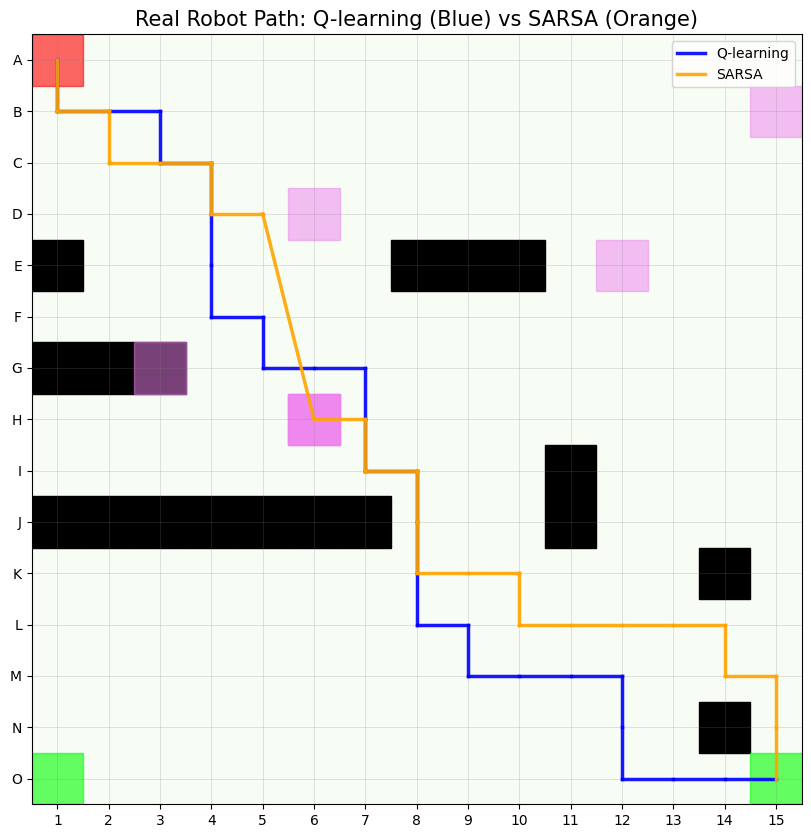

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_real_path(agent, Envir, start_state=0, max_steps=300):
    """Sinh đường đi thật của agent sau huấn luyện"""
    path = [start_state]
    state = start_state
    total_reward = 0

    for _ in range(max_steps):
        best_action = max(agent.Q_table[state], key=lambda a: agent.Q_table[state][a][0])
        next_state, _, reward = Envir.get_Observation(state, best_action)
        total_reward += reward

        # teleport → chỉ đánh dấu, không nối
        if next_state in Envir.start:
            path.append(next_state)
            total_reward += Envir.reward[Envir.start.index(next_state)]
            next_state = Envir.end[Envir.start.index(next_state)]

        path.append(next_state)
        if next_state in Envir.terminal_states:
            break
        state = next_state

    return path, total_reward

# ---- Đường đi thực tế ----
path_q, reward_q = simulate_real_path(dummy_q_agent, Envir)
path_s, reward_s = simulate_real_path(dummy_sarsa_agent, Envir)

print(f"Q-learning path length: {len(path_q)-1} steps | Total reward: {reward_q}")
print(f"SARSA path length: {len(path_s)-1} steps | Total reward: {reward_s}")

# ---- Chuẩn bị lưới hiển thị ----
Y_Cord = [chr(65 + i) for i in range(Envir.height)]  # A→O
X_Cord = [str(i + 1) for i in range(Envir.width)]    # 1→15
Map = np.zeros((Envir.height, Envir.width))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(Map, cmap="Greens", interpolation="none", origin="upper")

# --- Vẽ tường ---
for w in Envir.walls:
    i, j = divmod(w, Envir.width)
    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color="black"))

# --- Teleport ---
for s, e in zip(Envir.start, Envir.end):
    si, sj = divmod(s, Envir.width)
    ei, ej = divmod(e, Envir.width)
    for (x, y) in [(sj, si), (ej, ei)]:
        ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, color="violet", alpha=0.5))

# --- Goal ---
for g in Envir.terminal_states:
    gi, gj = divmod(g, Envir.width)
    ax.add_patch(plt.Rectangle((gj-0.5, gi-0.5), 1, 1, color="lime", alpha=0.6))

# --- Start ---
start_i, start_j = divmod(path_q[0], Envir.width)
ax.add_patch(plt.Rectangle((start_j-0.5, start_i-0.5), 1, 1, color="red", alpha=0.6))

# --- Đường Q-learning ---
coords_q = [divmod(s, Envir.width) for s in path_q]
for k in range(len(coords_q)-1):
    if path_q[k] in Envir.start:
        continue
    y1, x1 = coords_q[k]
    y2, x2 = coords_q[k+1]
    ax.plot([x1, x2], [y1, y2], color="blue", linewidth=2.5, alpha=0.9, label="Q-learning" if k==0 else "")

# --- Đường SARSA ---
coords_s = [divmod(s, Envir.width) for s in path_s]
for k in range(len(coords_s)-1):
    if path_s[k] in Envir.start:
        continue
    y1, x1 = coords_s[k]
    y2, x2 = coords_s[k+1]
    ax.plot([x1, x2], [y1, y2], color="orange", linewidth=2.5, alpha=0.9, label="SARSA" if k==0 else "")

# --- Cấu hình hiển thị ---
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
ax.grid(True, which='major', color='gray', linewidth=0.5, alpha=0.3)

ax.set_xlim(-0.5, Envir.width-0.5)
ax.set_ylim(Envir.height-0.5, -0.5)
ax.set_title("Real Robot Path: Q-learning (Blue) vs SARSA (Orange)", fontsize=15)
ax.legend(loc="upper right")
plt.show()
